In [3]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ExpSineSquared, RationalQuadratic


mat_data = scipy.io.loadmat('DDD_001.mat')

gamma_cg = mat_data['gamma_cg']
l_bar_sys = mat_data['l_bar_sys']
rho_sys = mat_data['rho_sys']
schmid_factor = mat_data['schmid_factor']
sigma = mat_data['sigma_sys']
sigma_i = sigma * schmid_factor
time_cg = mat_data['time_cg']

In [4]:
t = time_cg.flatten() * 1e6
rhoData = rho_sys*1e-10
gammaData = gamma_cg*1e4

smoothedRho0 = np.zeros((12))
smoothedGamma0 = np.zeros((12))

In [15]:
smoothedRho = np.zeros((73, 12))
smoothedGamma = np.zeros((73, 12))
smoothedRhoDot = np.zeros((73, 12))
smoothedGammaDot = np.zeros((73, 12))

sampleLen = 1000
smoothedRhoExtra = np.zeros((sampleLen, 12))
smoothedGammaExtra = np.zeros((sampleLen, 12))
smoothedRhoDotExtra = np.zeros((sampleLen, 12))
smoothedGammaDotExtra = np.zeros((sampleLen, 12))
tExtra = np.linspace(t[0], t[-1], sampleLen)

#kernel = 1.0*RBF(length_scale=10, length_scale_bounds=(1e-2, 1e3)) + 1.0*WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 100)) #(my kernel)
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1)) #(helen's kernel)
for i in range(12):
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, n_restarts_optimizer=10).fit(t.reshape(-1, 1), rhoData[:, i].reshape(-1, 1))
    #plt.plot(t, gpr.predict(t.reshape(-1, 1)), label="GPR-smoothed rho_"+str(i+1))
    #plt.plot(t, rhoData[:, i], label="rho_"+str(i+1))
    #plt.legend()
    #plt.title(f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}")
    #plt.show()
    smoothedRho[:, i] = gpr.predict(t.reshape(-1, 1))
    for j in range(73):
        deltaT = 0.001
        l = gpr.predict((t[j]-deltaT).reshape(1, -1))[0]
        r = gpr.predict((t[j]+deltaT).reshape(1, -1))[0]
        smoothedRhoDot[j, i] = (r-l)/(2*deltaT)
    smoothedRho0[i] = gpr.predict(np.array(0).reshape(1, -1))[0]

    smoothedRhoExtra[:, i] = gpr.predict(tExtra.reshape(-1, 1))
    for j in range(sampleLen):
        deltaT = 0.001
        l = gpr.predict((tExtra[j]-deltaT).reshape(1, -1))[0]
        r = gpr.predict((tExtra[j]+deltaT).reshape(1, -1))[0]
        smoothedRhoDotExtra[j, i] = (r-l)/(2*deltaT)    

kernel = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
for i in range(12):
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, n_restarts_optimizer=10).fit(t.reshape(-1, 1), gammaData[:, i].reshape(-1, 1))
    #plt.plot(t, gpr.predict(t.reshape(-1, 1)), label="GPR-smoothed gamma_"+str(i+1))
    #plt.plot(t, gammaData[:, i], label="gamma_"+str(i+1))
    #plt.legend()
    #plt.title(f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}")
    #plt.show()
    smoothedGamma[:, i] = gpr.predict(t.reshape(-1, 1))
    for j in range(73):
        deltaT = 0.001
        l = gpr.predict((t[j]-deltaT).reshape(1, -1))[0]
        r = gpr.predict((t[j]+deltaT).reshape(1, -1))[0]
        smoothedGammaDot[j, i] = (r-l)/(2*deltaT)
    smoothedGamma0[i] = gpr.predict(np.array(0).reshape(1, -1))[0]

    smoothedGammaExtra[:, i] = gpr.predict(tExtra.reshape(-1, 1))
    for j in range(sampleLen):
        deltaT = 0.001
        l = gpr.predict((tExtra[j]-deltaT).reshape(1, -1))[0]
        r = gpr.predict((tExtra[j]+deltaT).reshape(1, -1))[0]
        smoothedGammaDotExtra[j, i] = (r-l)/(2*deltaT)    

C:\Users\xiast\anaconda3\envs\Research\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [4]:
np.save("smoothedRho", np.stack((smoothedRho, smoothedRho+1, smoothedRho+2, smoothedRho+3, smoothedRho+4, smoothedRho+5, smoothedRho+6)))
np.save("smoothedGamma", np.stack((smoothedGamma, smoothedGamma+1, smoothedGamma+2, smoothedGamma+3, smoothedGamma+4, smoothedGamma+5, smoothedGamma+6)))
np.save("smoothedRhoDot", np.stack((smoothedRhoDot, smoothedRhoDot+1, smoothedRhoDot+2, smoothedRhoDot+3, smoothedRhoDot+4, smoothedRhoDot+5, smoothedRhoDot+6)))
np.save("smoothedGammaDot", np.stack((smoothedGammaDot, smoothedGammaDot+1, smoothedGammaDot+2, smoothedGammaDot+3, smoothedGammaDot+4, smoothedGammaDot+5, smoothedGammaDot+6)))
np.save("smoothedt", t)

np.tile(smoothedGamma, (3, 1, 1)).shape

(3, 73, 12)

In [19]:
np.save("LsmoothedRho", np.tile(smoothedRhoExtra, (3, 1, 1)))
np.save("LsmoothedGamma", np.tile(smoothedGammaExtra, (3, 1, 1)))
np.save("LsmoothedRhoDot", np.tile(smoothedRhoDotExtra, (3, 1, 1)))
np.save("LsmoothedGammaDot", np.tile(smoothedGammaDotExtra, (3, 1, 1)))
np.save("Lsmoothedt", tExtra)

In [5]:
finiteDifferenceRhoDot = np.zeros((71, 12))
finiteDifferenceGammaDot = np.zeros((71, 12))
for j in range(71):
    finiteDifferenceRhoDot[j] = (rhoData[j+1]-rhoData[j-1])/(t[j+1]-t[j-1])
    finiteDifferenceGammaDot[j] = (gammaData[j+1]-gammaData[j-1])/(t[j+1]-t[j-1])

In [6]:
def plotGraphs(arr1, name1, arr2, name2, t, symbol, modified=False):
    #plt.rcParams['text.usetex'] = False
    fig, axs = plt.subplots(3, 4)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    for r in range(3):
        for c in range(4):
            i = r+3*c;
            if modified:
                axs[r, c].plot(t[1:-1], arr1[:,i], color='tab:blue')
            else:
                axs[r, c].plot(t, arr1[:,i], color='tab:blue')
            axs[r, c].plot(t, arr2[:,i], color='tab:red')
            axs[r, c].set_title("$"+f'{symbol}'+"_{" + f'{i+1}' + "}$")
            #axs[r, c].legend()
    fig.suptitle(f'{name1} and {name2}')

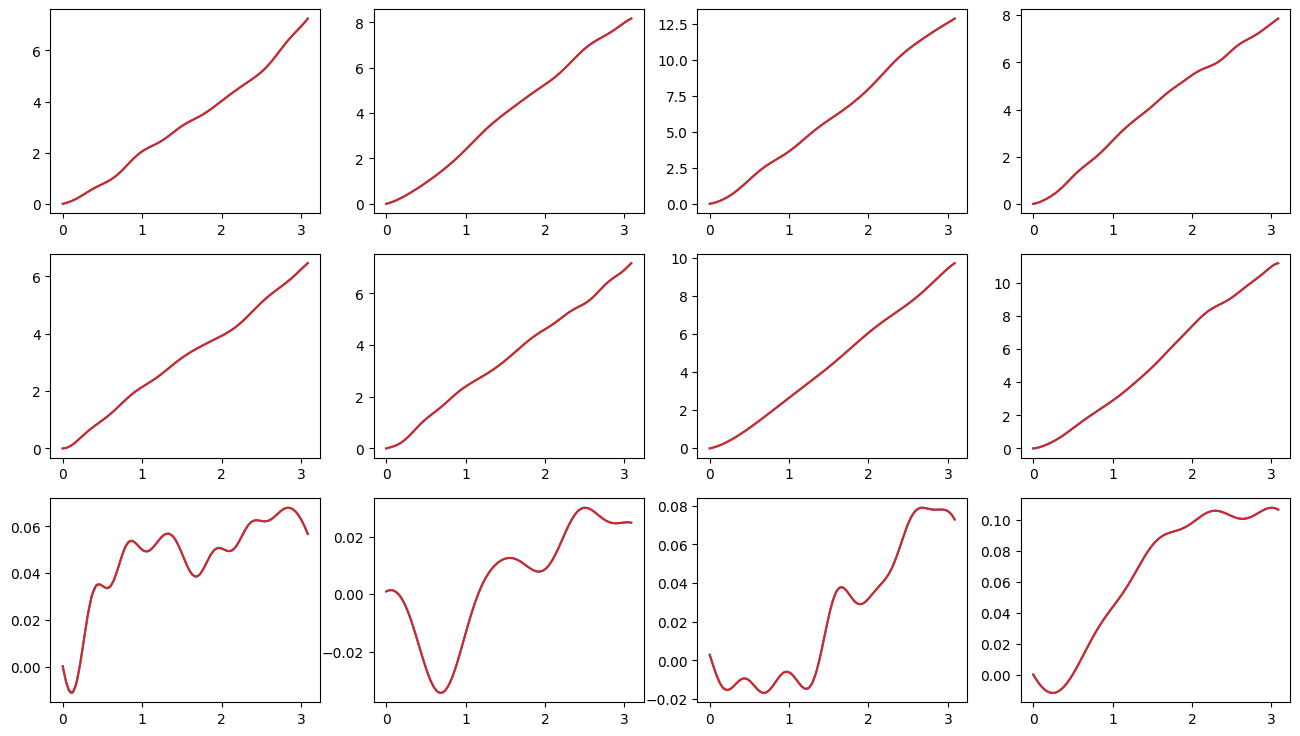

In [18]:
fig, axs = plt.subplots(3, 4)
fig.set_figheight(9)
fig.set_figwidth(16)
for r in range(3):
    for c in range(4):
        i = r+3*c;
        axs[r, c].plot(tExtra, smoothedGammaExtra[:,i], color='tab:blue')
        axs[r, c].plot(t, smoothedGamma[:,i], color='tab:red')
        # axs[r, c].plot(t, arr2[:,i], color='tab:red')
        # axs[r, c].set_title("$"+f'{symbol}'+"_{" + f'{i+1}' + "}$")

In [ ]:
plotGraphs(rhoData, "raw data rho", smoothedRho, "smoothed rho", t, "\\rho")
plotGraphs(gammaData, "raw data gamma", smoothedGamma, "smoothed gamma", t, "\\gamma")

In [ ]:
plotGraphs(finiteDifferenceRhoDot, "finite diff. rhodot", smoothedRhoDot, "smoothed central diff. rhodot", t, "\\dot{\\rho}", True)
plotGraphs(finiteDifferenceGammaDot, "finite diff. gammadot", smoothedGammaDot, "smoothed central diff. gammadot", t, "\\dot{\\gamma}", True)

In [9]:
def loss_fn(coeffs):
    B = coeffs[:12*12].reshape((12, 12))
    C = coeffs[12*12:].reshape((12,12))
    B = B + B.T
    C = C + C.T
    y_pred = smoothedRho @ (B + B.T) + smoothedGamma @ (C + C.T)
    return ((y_pred-smoothedRhoDot)**2).mean()

alpha_init = np.identity(12)
beta_init = np.identity(12)
coeffs = np.append(alpha_init.flatten(), beta_init.flatten())
result = minimize(loss_fn, coeffs, method='BFGS', options={'maxiter':10000})

Bfinal = result.x[:12*12].reshape((12, 12))
Cfinal = result.x[12*12:].reshape((12, 12))
rhoDotPredicted = smoothedRho @ (Bfinal.T + Bfinal) + smoothedGamma @ (Cfinal.T + Cfinal)

In [10]:
#plotGraphs(finiteDifferenceRhoDot, "finiteDifference rhodot", rhoDotPredicted, "predicted rhodot", t, True)

In [37]:
def A(arr):
    s, cp, h, l, cl, gl = arr[0], arr[1], arr[2], arr[3], arr[4], arr[5]
    return [[s, cp, cp, cl, gl, gl, h, gl, l, h, l, gl], [cp, s, cp, gl, h, l, gl, cl, gl, l, h, gl], [cp, cp, s, gl, l, h, l, gl, h, gl, gl, cl], [cl, gl, gl, s, cp, cp, h, l, gl, h, gl, l], [gl, h, l, cp, s, cp, l, h, gl, gl, cl, gl], [gl, l, h, cp, cp, s, gl, gl, cl, l, gl, h], [h, gl, l, h, l, gl, s, cp, cp, cl, gl, gl], [gl, cl, gl, l, h, gl, cp, s, cp, gl, h, l], [l, gl, h, gl, gl, cl, cp, cp, s, gl, l, h], [h, l, gl, h, gl, l, cl, gl, gl, s, cp, cp], [l, h, gl, gl, cl, gl, gl, h, l, cp, s, cp], [gl, gl, cl, l, gl, h, gl, l, h, cp, cp, s]]

def loss_fn2(coeffs):
    c1b = 2e6 #coeffs[6]
    c2 = coeffs[7]
    c3b = coeffs[8]
    Aij = np.array(A(coeffs[:6]))
    # Aij = np.array(A([0.122, 0.122, 0.07, 0.122, 0.137, 0.635]))

    y_pred = np.zeros((73, 12))
    i2, i3 = 0, 0
    for i in range(12):
        if (i % 3 == 0):
            i2 = i+1
            i3 = i+2
        elif (i % 3 == 1):
            i2 = i-1
            i3 = i+1
        else:
            i2 = i-1
            i3 = i-2

        for time in range(73):
            y_pred[time, i] = smoothedGammaDot[time, i] * (c1b * np.sqrt(np.dot(Aij[i], smoothedRho[time, :])) - c2 * smoothedRho[time, i]) + c3b * (smoothedGammaDot[time, i2]*np.sqrt(smoothedRho[time, i3]) + smoothedGammaDot[time, i3]*np.sqrt(smoothedRho[time, i2]))
    return ((y_pred - smoothedRhoDot)**2).mean()

coeffs = np.ones(9)
# def con1():
#     for i in range(9):
#         if coeffs[i] < 0:
#             return -1
#     return 1

result = minimize(loss_fn2, coeffs, method='L-BFGS-B', options={'maxiter': 1000}, bounds=[(0, 10000), (0, 10000), (0, 10000), (0, 10000), (0, 10000), (0, 10000), (0, 10000), (0, 10000), (0, 10000)])
c1bresult = 2e6 #result.x[6]
c2result = result.x[7]
c3bresult = result.x[8]
Aijresult = np.array(A(result.x[:6]))

# c1bresult = 2.094e6 * 1e-9
# c2result = 418 * 1e-4
# c3bresult = 1.052e8 * 1e-9
# Aijresult = np.array(A([0.122, 0.122, 0.07, 0.122, 0.137, 0.635]))

rhoDotPredicted = np.zeros((73, 12))
for i in range(12):
    if (i % 3 == 0):
            i2 = i+1
            i3 = i+2
    elif (i % 3 == 1):
        i2 = i-1
        i3 = i+1
    else:
        i2 = i-1
        i3 = i-2
    for time in range(73):
        rhoDotPredicted[time, i] = smoothedGammaDot[time, i] * (c1bresult * np.sqrt(np.dot(Aijresult[i], smoothedRho[time, :])) - c2result * smoothedRho[time, i]) + c3bresult * (smoothedGammaDot[time, i2]*np.sqrt(smoothedRho[time, i3]) + smoothedGammaDot[time, i3]*np.sqrt(smoothedRho[time, i2]))

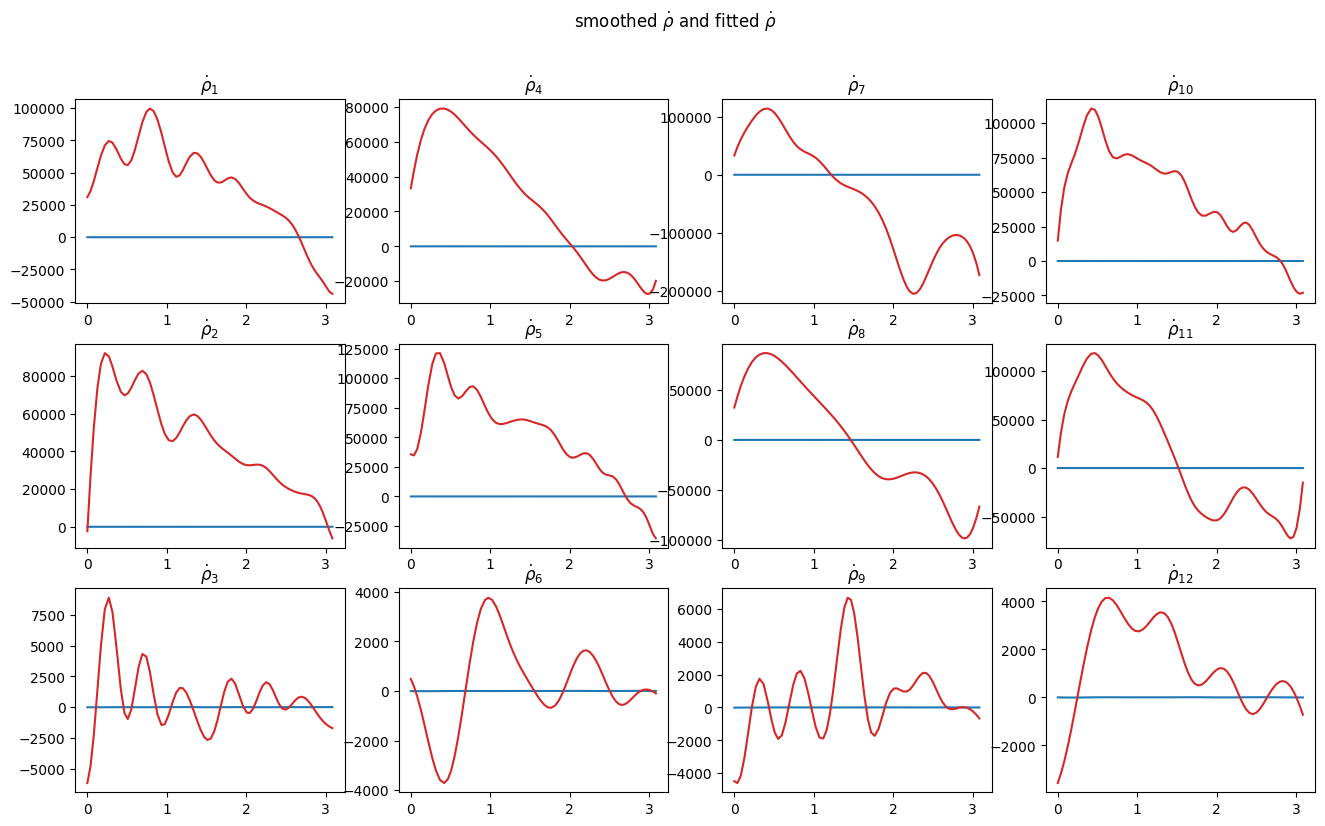

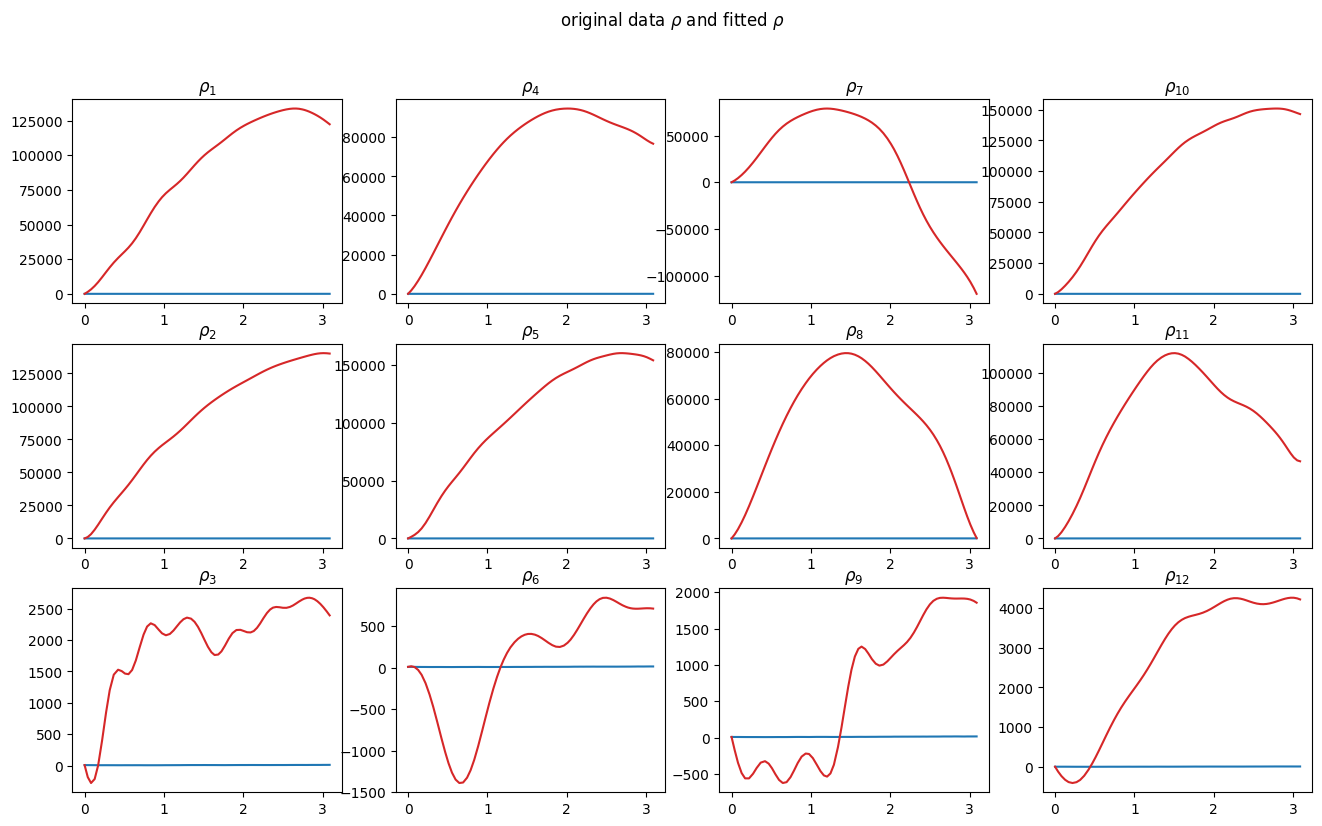

In [38]:
fittedRho = np.zeros((73, 12))
fittedGamma = np.zeros((73, 12))
fittedRho[0, :] = smoothedRho0
fittedGamma[0, :] = smoothedGamma0

for i in range(72):
    fittedRho[i+1, :] = fittedRho[i, :] + rhoDotPredicted[i+1, :] * (t[i+1]-t[i])
    #fittedGamma[i+1, :] = fittedGamma[i, :] + gammaDotPredicted[i, :] * (t[i+1]-t[i])

plotGraphs(smoothedRhoDot, "smoothed $\dot{\\rho}$", rhoDotPredicted, "fitted $\dot{\\rho}$", t, "\dot{\\rho}")
plotGraphs(rhoData,"original data $\\rho$",fittedRho, "fitted $\\rho$", t, "\\rho")

In [39]:
result.x

array([4.29940301e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.99959355e+03,
       4.06491383e-05])

In [14]:
def Discover(r, gd):
    pred = np.zeros((73, 12))
    coeffs = np.zeros((12, 14))
    coeffs[0] = [-7.24, 0.256, 7576, -4351, 4537, 3558, -6477, 19071, -1127, 13864, -26600, 104, -19265, 20462]
    coeffs[1] = [-26.17, 1.452, 8.34, 5469, 76.8, 5444, -1166, 1437, -1590, -5607, -4692, -98, 2821, 1758]
    coeffs[2] = [-229.45, 17.29,1627 ,1941.5, -200.8, -10417, -1923, -1588, 4363, 12774, -4278, -1626, -7597, 7219]
    
    for tt in range(73):
        pred[tt, 0] = (gd[tt,10]+gd[tt,6]+gd[tt,11]/(gd[tt,3]+r[tt,0]+(r[tt,7]/(r[tt,5]*np.sqrt(np.sqrt(gd[tt,1]*(1+gd[tt,5]/gd[tt,1]))))))**2)**2
        pred[tt, 0] += gd[tt,0] * (r[tt,0] * coeffs[0, 0] + coeffs[0, 1] * np.sqrt(np.dot(coeffs[0, 2:], r[tt,:])))

        pred[tt, 1] = gd[tt,3] + gd[tt,5]*(gd[tt,4]/r[tt,8]*(r[tt,11]+np.sqrt(gd[tt,1]*(gd[tt,7]+np.sqrt(r[tt,8]/r[tt,6]*np.sqrt(r[tt,1]+np.sqrt(r[tt,6]*r[tt,3]*r[tt,7])))))))**2
        pred[tt, 1] += gd[tt,3] * gd[tt,6] * gd[tt,7]
        
        pred[tt, 2] = (gd[tt,5] + np.sqrt(np.sqrt(np.sqrt(r[tt,4]/r[tt,3]/gd[tt,4]*r[tt,0]/r[tt,1]*gd[tt,3]*(gd[tt,10]+r[tt,1]+gd[tt,0]+gd[tt,0]*gd[tt,4]*gd[tt,9]**2)))))**2
        pred[tt, 2] += gd[tt,2] * (r[tt,2] * coeffs[2, 0] + coeffs[2, 1] * np.sqrt(np.dot(coeffs[2, 2:], r[tt,:])))

    return pred    

def DiscoverBaseline(r, gd):
    pred = np.zeros((73, 12))

    pred[:, 0] = 2*18.092*gd[:,1]-5.04*r[:,4]-6.269*r[:,1]-476.5*gd[:,11]-1.38*r[:,6]-32.55*gd[:,0]-0.259*r[:,11]+11.1*gd[:,6]+4.01*r[:,7]-3*gd[:,5]-1.38*r[:,6]+9.05*r[:,5]-327*gd[:,8]
    pred[:, 1] = 45.46*gd[:,3]/r[:,4]+0.56*r[:,0]-36.6*gd[:,3]-13.24*gd[:,0]-3.009*r[:,11]-0.73*r[:,6]+6.077*gd[:,1]+1.43*r[:,2]+1.305*r[:,8]+36.1*gd[:,7]
    pred[:, 2] = 29.007*gd[:,2]-14.69*gd[:,1]+0.6*r[:,6]+0.76*r[:,11]-2.177*r[:,7]+3.063*r[:,0]-4.66*r[:,4]+9.15*gd[:,7]+6.27*r[:,9]+1.31*gd[:,10]+0.119*r[:,8]+2.963*r[:,2]-1.64*r[:,3]-6.08*r[:,5]
    return pred   

C:\Users\xiast\AppData\Local\Temp\ipykernel_20160\2978239964.py:9: RuntimeWarning: invalid value encountered in sqrt
  pred[tt, 0] = (gd[tt,10]+gd[tt,6]+gd[tt,11]/(gd[tt,3]+r[tt,0]+(r[tt,7]/(r[tt,5]*np.sqrt(np.sqrt(gd[tt,1]*(1+gd[tt,5]/gd[tt,1]))))))**2)**2
C:\Users\xiast\AppData\Local\Temp\ipykernel_20160\2978239964.py:12: RuntimeWarning: invalid value encountered in sqrt
  pred[tt, 1] = gd[tt,3] + gd[tt,5]*(gd[tt,4]/r[tt,8]*(r[tt,11]+np.sqrt(gd[tt,1]*(gd[tt,7]+np.sqrt(r[tt,8]/r[tt,6]*np.sqrt(r[tt,1]+np.sqrt(r[tt,6]*r[tt,3]*r[tt,7])))))))**2


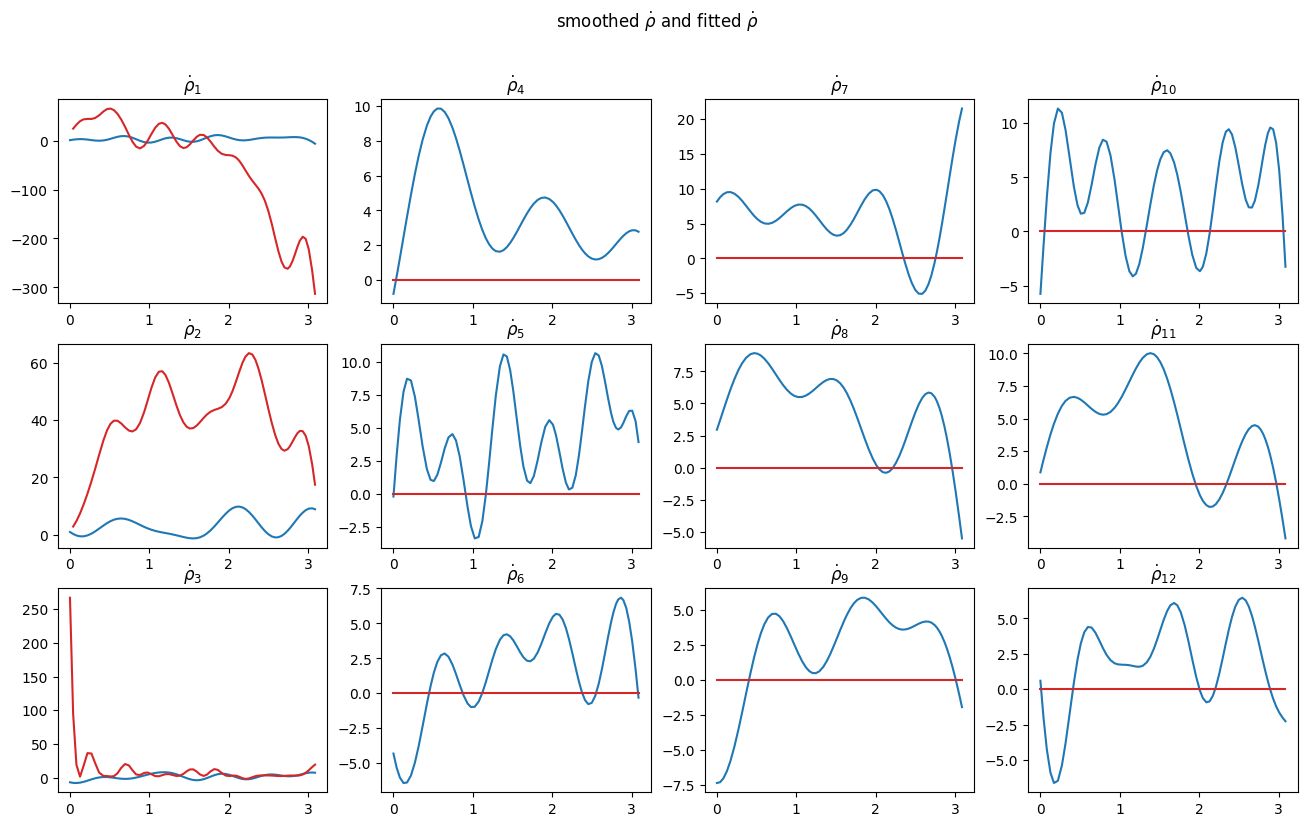

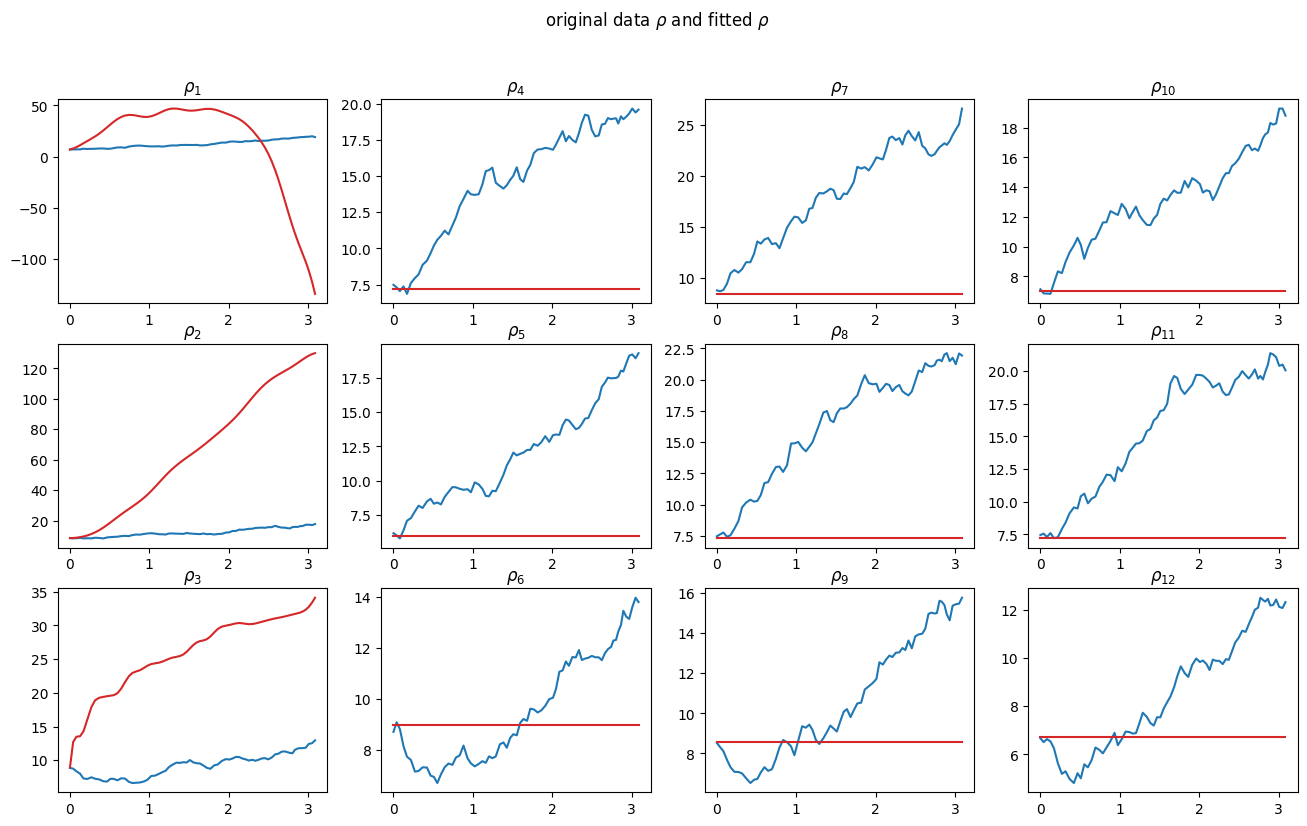

In [15]:
rhoDotDiscoverPred = Discover(smoothedRho, smoothedGammaDot)
fittedRho = np.zeros((73, 12))
fittedGamma = np.zeros((73, 12))
fittedRho[0, :] = smoothedRho0
fittedGamma[0, :] = smoothedGamma0

for i in range(72):
    fittedRho[i+1, :] = fittedRho[i, :] + rhoDotDiscoverPred[i+1, :] * (t[i+1]-t[i])
    #fittedGamma[i+1, :] = fittedGamma[i, :] + gammaDotPredicted[i, :] * (t[i+1]-t[i])

plotGraphs(smoothedRhoDot, "smoothed $\dot{\\rho}$", rhoDotDiscoverPred, "fitted $\dot{\\rho}$", t, "\dot{\\rho}")
plotGraphs(rhoData,"original data $\\rho$",fittedRho, "fitted $\\rho$", t, "\\rho")

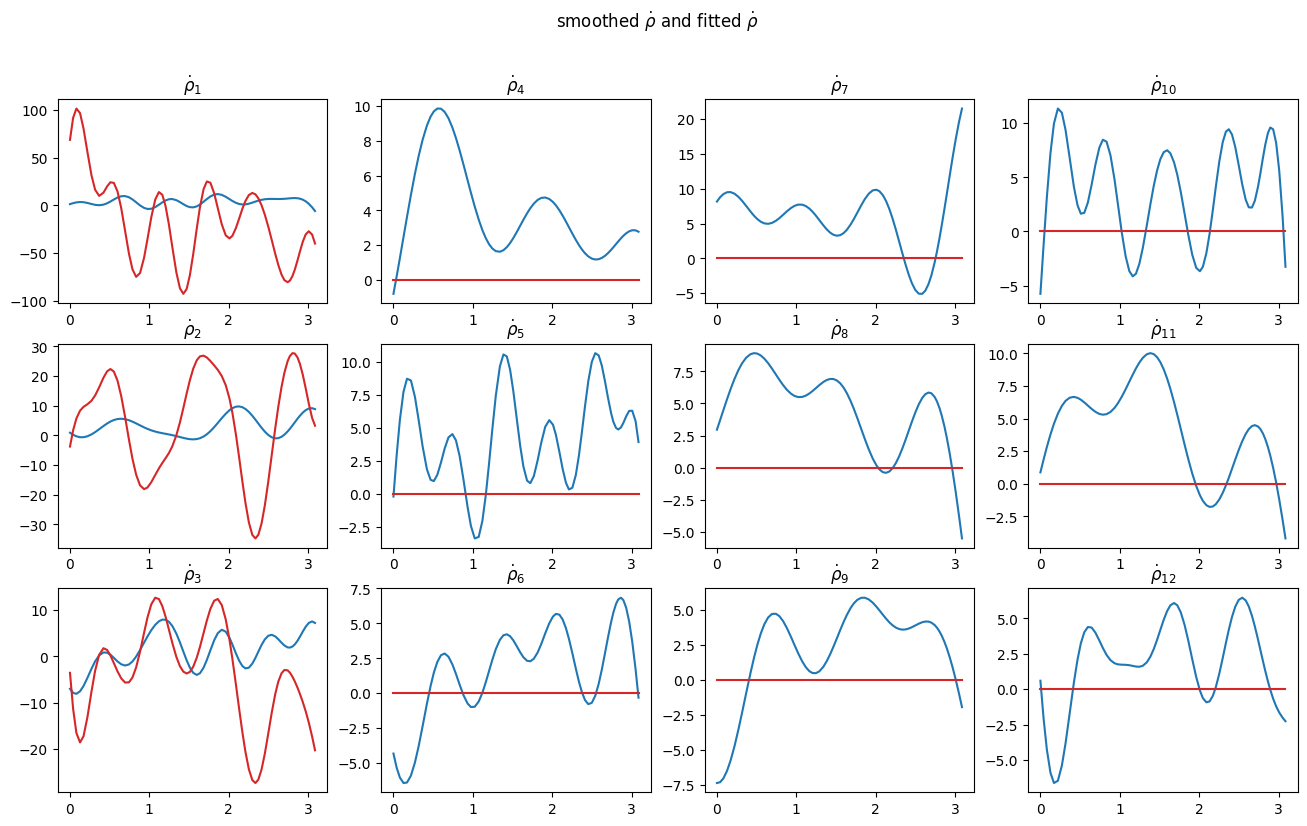

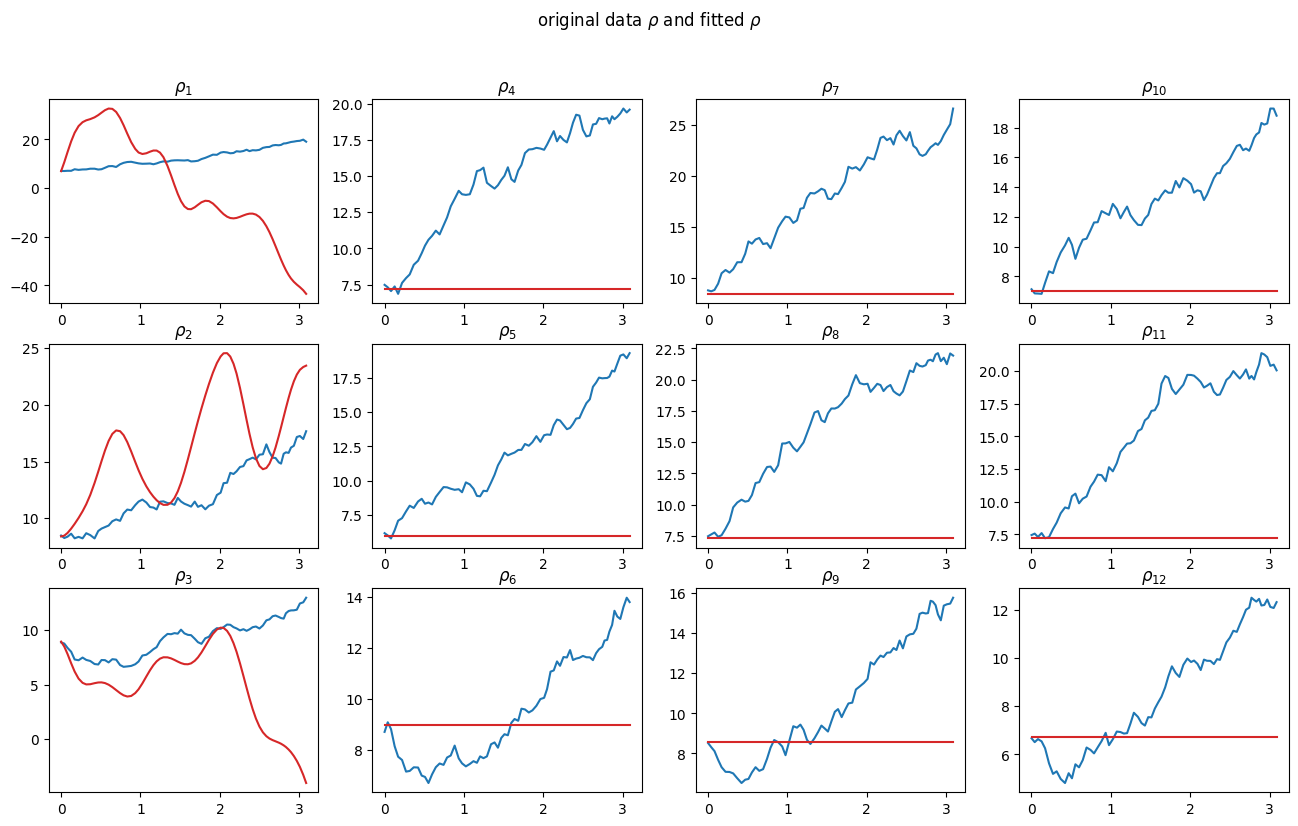

In [16]:
rhoDotDiscoverPred = DiscoverBaseline(smoothedRho, smoothedGammaDot)
fittedRho = np.zeros((73, 12))
fittedGamma = np.zeros((73, 12))
fittedRho[0, :] = smoothedRho0
fittedGamma[0, :] = smoothedGamma0

for i in range(72):
    fittedRho[i+1, :] = fittedRho[i, :] + rhoDotDiscoverPred[i+1, :] * (t[i+1]-t[i])
    #fittedGamma[i+1, :] = fittedGamma[i, :] + gammaDotPredicted[i, :] * (t[i+1]-t[i])

plotGraphs(smoothedRhoDot, "smoothed $\dot{\\rho}$", rhoDotDiscoverPred, "fitted $\dot{\\rho}$", t, "\dot{\\rho}")
plotGraphs(rhoData,"original data $\\rho$",fittedRho, "fitted $\\rho$", t, "\\rho")